<a href="https://colab.research.google.com/github/nickwan/nwds-stream-notebooks/blob/main/effective_stuff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# font

In [ ]:
def increase_font():
  from IPython.display import Javascript
  display(Javascript('''
  for (rule of document.styleSheets[0].cssRules){
    if (rule.selectorText=='body') {
      rule.style.fontSize = '24px'
      break
    }
  }
  '''))
get_ipython().events.register('pre_run_cell', increase_font)

# effective stuff  
is per-pitch stuff wack?  

In [ ]:
%load_ext cuml.accel
%load_ext cudf.pandas

<IPython.core.display.Javascript object>

[2025-04-16 02:46:14.623] [CUML] [info] cuML: Installed accelerator for sklearn.
[2025-04-16 02:46:40.978] [CUML] [info] cuML: Installed accelerator for umap.
[2025-04-16 02:46:41.056] [CUML] [info] cuML: Installed accelerator for hdbscan.
[2025-04-16 02:46:41.056] [CUML] [info] cuML: Successfully initialized accelerator.


/usr/local/lib/python3.11/dist-packages/cudf/pandas/__init__.py:65: UserWarning: cudf.pandas detected an already configured memory resource, ignoring 'CUDF_PANDAS_RMM_MODE'=managed_pool
  warnings.warn(


In [ ]:
!pip install -U pandas
!pip install catboost
!pip install pybaseball


<IPython.core.display.Javascript object>

In [ ]:
# some of this is boiler plate and can be reduced.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.preprocessing import QuantileTransformer, minmax_scale
from sklearn.neighbors import KernelDensity
from scipy.stats import pearsonr, spearmanr, percentileofscore
import catboost as cb
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm

project_dir = 'drive/My Drive/2024-MLB'

<IPython.core.display.Javascript object>

In [ ]:
def draw_sz(sz_top=3.5, sz_bot=1.5, ls='k-'):
  """
  draw strike zone
  draw the strike zone on a plot using mpl
  inputs:
    sz_top: top of strike zone (ft)
    sz_bot: bottom of strike zone (ft)
    ls: linestyle (use `plt.plot()` linestyle conventions)
  output:
    strike zone plot
  """
  plt.plot([-0.708, 0.708], [sz_bot,sz_bot], ls)
  plt.plot([-0.708, -0.708], [sz_bot,sz_top], ls)
  plt.plot([0.708, 0.708], [sz_bot,sz_top], ls)
  plt.plot([-0.708, 0.708], [sz_top,sz_top], ls)

def draw_home_plate(catcher_perspective=True, ls='k-'):
  """
  draw home plate from either the catcher perspective or pitcher perspective
  inputs:
    catcher_perspective: orient home plate in the catcher POV. if False, orients
      home plate in the pitcher POV.
    ls: linestyle (use `plt.plot()` linestyle conventions)
  output:
    home plate plot
  """
  if catcher_perspective:
    plt.plot([-0.708, 0.708], [0,0], ls)
    plt.plot([-0.708, -0.708], [0,-0.3], ls)
    plt.plot([0.708, 0.708], [0,-0.3], ls)
    plt.plot([-0.708, 0], [-0.3, -0.6], ls)
    plt.plot([0.708, 0], [-0.3, -0.6], ls)
  else:
    plt.plot([-0.708, 0.708], [0,0], ls)
    plt.plot([-0.708, -0.708], [0,0.1], ls)
    plt.plot([0.708, 0.708], [0,0.1], ls)
    plt.plot([-0.708, 0], [0.1, 0.3], ls)
    plt.plot([0.708, 0], [0.1, 0.3], ls)

def draw_attack_zones():
  """
  draw attack zones
  draw the statcast attack zones on a plot using mpl
  inputs:
    none! lulw
  output:
    attack zone plot
  """

  # outer heart / inner shadow
  plt.plot([-0.558, 0.558], [1.833,1.833], color=(227/255, 150/255, 255/255), ls='-', lw=3)
  plt.plot([-0.558, -0.558], [1.833,3.166], color=(227/255, 150/255, 255/255), ls='-', lw=3)
  plt.plot([0.558, 0.558], [1.833,3.166], color=(227/255, 150/255, 255/255), ls='-', lw=3)
  plt.plot([-0.558, 0.558], [3.166,3.166], color=(227/255, 150/255, 255/255), ls='-', lw=3)

  # outer shadow /  inner chase
  plt.plot([-1.108, 1.108], [1.166,1.166], color=(255/255, 197/255, 150/255), ls='-', lw=3)
  plt.plot([-1.108, -1.108], [1.166,3.833], color=(255/255, 197/255, 150/255), ls='-', lw=3)
  plt.plot([1.108, 1.108], [1.166,3.833], color=(255/255, 197/255, 150/255), ls='-', lw=3)
  plt.plot([-1.108, 1.108], [3.833,3.833], color=(255/255, 197/255, 150/255), ls='-', lw=3)

  # outer chase
  plt.plot([-1.666, 1.666], [0.5,0.5], color=(209/255, 209/255, 209/255), ls='-', lw=3)
  plt.plot([-1.666, -1.666], [0.5,4.5], color=(209/255, 209/255, 209/255), ls='-', lw=3)
  plt.plot([1.666, 1.666], [0.5,4.5], color=(209/255, 209/255, 209/255), ls='-', lw=3)
  plt.plot([-1.666, 1.666], [4.5,4.5], color=(209/255, 209/255, 209/255), ls='-', lw=3)

<IPython.core.display.Javascript object>

In [ ]:
df = pd.read_csv(f'{project_dir}/stuff_xrv.csv')
df['attack_zone'] = 'waste'
df.loc[(df['plate_x'].between(-0.558, 0.558)) & (df['plate_z'].between(1.833,3.166)), 'attack_zone'] = 'heart'
df.loc[(df['plate_x'].between(-1.108, 1.108)) & (df['plate_z'].between(1.166,3.833)) & (~df['attack_zone'].isin(['heart'])), 'attack_zone'] = 'shadow'
df.loc[(df['plate_x'].between(-1.666, 1.666)) & (df['plate_z'].between(0.5,4.5)) & (~df['attack_zone'].isin(['heart', 'shadow'])), 'attack_zone'] = 'chase'

df['is_lhb'] = df['stand'].map({'R':0,'L':1})
df['scaled_ofset_x'] = np.absolute(df['plate_x'])
df['scaled_ofset_z'] = np.absolute(df['plate_z'] - 2.500)/1.200
df['scaled_ofset_xz'] = np.maximum(df['scaled_ofset_x'],df['scaled_ofset_z'])
df['p_est'] = 0.5*(1.0-np.tanh(6.4*(df['scaled_ofset_xz']-0.84)))
df['ellip_dist'] = np.sqrt(df['scaled_ofset_x']**2 + df['scaled_ofset_z']**2)
df['description'].value_counts()

strikes = [
    'swinging_strike', 'called_strike', 'swinging_strike_blocked'
]

df['is_strike'] = df['description'].isin(strikes).astype(int)

<IPython.core.display.Javascript object>

In [ ]:
df.columns.values

<IPython.core.display.Javascript object>

array(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year',
       'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'umpire', 'sv_id', 'vx0',
       'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle',
       'effective_speed', 'release_spin_rate', 'release_extension',
       'game_pk', 'fielder_2', 'fielder_3', 'fielder_4', 'fielder_5',
       'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9',
       'release_pos_y', 'estimated_ba_using_speedangle',
  

In [ ]:
feats = [
    'is_lhb', 'is_lhp', 'plate_x', 'plate_z','pfx_x',
    'pfx_z', 'release_speed', 'release_pos_x', 'release_pos_z',
    'release_extension','scaled_ofset_x', 'scaled_ofset_z',
    'scaled_ofset_xz', 'p_est', 'ellip_dist'
]

target = 'is_strike'

model_data = df.dropna(subset=feats+[target])
folds = 3
kf = KFold(n_splits=folds, shuffle=True)
s = pd.Series()
for train_idx, test_idx in tqdm(kf.split(model_data), total=folds):
  train = model_data.iloc[train_idx]
  test = model_data.iloc[test_idx]
  model = cb.CatBoostClassifier(verbose=False,task_type="GPU")
  model.fit(train.loc[:, feats], train[target])
  preds = pd.DataFrame(model.predict_proba(test.loc[:, feats]), index=test.index)[1]
  s = pd.concat([s, preds])

df['xstrike'] = s
df.shape

<IPython.core.display.Javascript object>

  0%|          | 0/3 [00:00<?, ?it/s]

(2286841, 137)

In [ ]:
id_feats = ['game_year','pitcher', 'player_name', 'pitch_type','pitch_name']
feats = ['release_speed', 'pfx_x_adj','pfx_z','release_pos_x','release_pos_z',
         'release_extension', 'release_speed_diff',
         'pfx_x_diff','pfx_z_diff','release_spin_rate', 'spin_axis_adj',
         'ssw_x', 'ssw_z']
target = 'xstrike'
model_data = df.loc[(df['bases_empty']==1) & (df['release_speed']>70) & (df['pfx_x'].between(-2,2)) & (df['pfx_z'].between(-2,2)) & (df['plate_x'].between(-1.667,1.667))].dropna(subset=id_feats+feats+[target])
holdout = df.loc[~df.index.isin(model_data.index.values)].dropna(subset=feats+[target])

folds = 3
kf = KFold(n_splits=folds, shuffle=True)
s = pd.DataFrame()

for train_idx, test_idx in tqdm(kf.split(model_data), total=folds):
  train = model_data.iloc[train_idx]
  test = model_data.iloc[test_idx]
  model = cb.CatBoostRegressor(verbose=False, loss_function='RMSE',task_type="GPU")
  model.fit(train.loc[:, feats], train[target])
  s = pd.concat([s, pd.Series(model.predict(test.loc[:, feats]), index=test.index)])

model = cb.CatBoostRegressor(verbose=False, loss_function='RMSE',task_type="GPU")
model.fit(model_data.loc[:, feats], model_data[target])
s = pd.concat([s, pd.Series(model.predict(holdout.loc[:, feats]), index=holdout.index)])

df['stuff_xstrike'] = s

<IPython.core.display.Javascript object>

  0%|          | 0/3 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

,stuff_xstrike
count,2143888.000
mean,0.290
std,0.031
min,0.022
25%,0.266
50%,0.287
75%,0.314
max,0.518


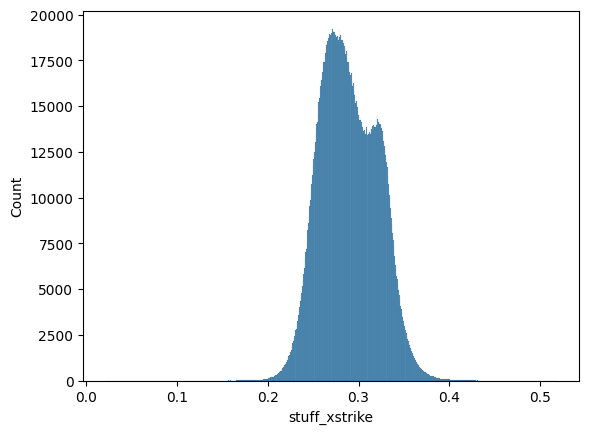

In [ ]:
sns.histplot(df['stuff_xstrike'])
df['stuff_xstrike'].describe().round(3)

<IPython.core.display.Javascript object>

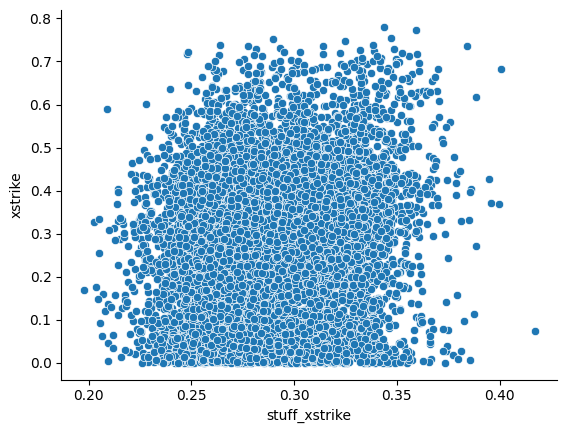

In [ ]:
sns.scatterplot(data=df.sample(10000), x='stuff_xstrike', y='xstrike')
sns.despine()
plt.show()

<IPython.core.display.Javascript object>

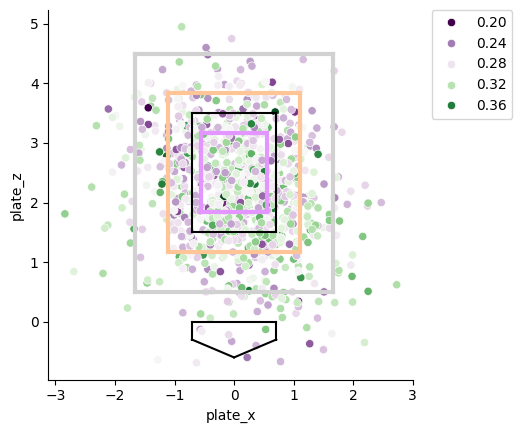

In [ ]:
df_plt = df.sample(1000)
sns.scatterplot(data=df_plt, x='plate_x', y='plate_z',
                hue='stuff_xstrike',palette='PRGn')
draw_sz()
draw_home_plate()
draw_attack_zones()
sns.despine()
plt.gca().set_aspect('equal')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()

In [ ]:
df.loc[:, ['stuff_xrv','stuff_xstrike']].describe().round(3)

<IPython.core.display.Javascript object>

,stuff_xrv,stuff_xstrike
count,2143732.000,2143888.000
mean,0.000,0.290
std,0.010,0.031
min,-0.113,0.022
25%,-0.006,0.266
50%,0.000,0.287
75%,0.007,0.314
max,0.285,0.518


In [ ]:
df.loc[:, ['attack_zone','is_strike', 'stuff_xrv','stuff_xstrike']].dropna().groupby('attack_zone', as_index=False).mean()

NameError: name 'df' is not defined